<section id="title-slide">
  <h1 class="title">The ABC of Computational Text Analysis</h1>
  <h2 class="subtitle">#11: NLP with Python</h2>
  <p class="author">Alex Flückiger</p><p class="date">11/25 May 2023</p>
</section>

# Overview Analysis

- get linguistic information from text
- explore differences between two corpora 
    - using politcial party programmes
- visualize term frequency over time
  - using 1 August speeches by Swiss Federal Councillors

# Run locally on your laptop

## Update the course material
1. Navigate to the course folde using `cd` in your command line
2. Update the files with `git pull`
3. If `git pull` doesn't work due to file conflicts, run `git restore .` first

## Getting started 
1. Open VS Code
2. Windows: Make sure that you are connected to WSL (green-badge in left-lower corner)
3. Open the `KED2023` folder via the menu: `File` > `Open Folder`
4. Navigate to `KED2023/materials/code/KED2023_11.ipynb` and open with double-click
5. Run the code with `Run all` via the top menu

# Google Colab

- When you run this code locally on your laptop, you can ignore this section. 

- When you run this code in Google Colab instead of locally, uncomment the following lines that the additional packages get installed and data is loaded.

In [ ]:
# !git clone https://github.com/aflueckiger/KED2023
# !cd /content/KED2023 && pip install -r requirements.txt


In [ ]:
# cd /content/KED2023/KED2023/materials/code


# Do Natural Language Processing (NLP)

## Modules
#### Standing of the Shoulders of Giants
- [spaCy](https://spacy.io/usage/spacy-101): use or build state-of-the-art NLP pipeline
- [textaCy](https://textacy.readthedocs.io): do high-level analysis, extends spaCy
- [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html): analyze tabular data 
- [plotnine](https://plotnine.readthedocs.io): visualize anything (*ggplot for Python*)

# Importing Modules

various ways of importing

In [ ]:
# standard import
import textacy
import spacy

# import with a short name
import pandas as pd


# import all specific/all objects from a module
from pathlib import Path
from plotnine import *


# Basic NLP
Process a single document

In [ ]:
# example text (to read from a file see below)
text = "Apple's CEO Tim Cook is looking at buying U.K. startup for $1 billion."

# load the English language model
en = textacy.load_spacy_lang("en_core_web_sm")

# process document (tokenizing, tagging, parsing, recognizing named entities)
doc = textacy.make_spacy_doc(text, lang=en)


## Linguistic Features
Features per token and their dependencies

In [ ]:
# visualize dependencies
spacy.displacy.render(doc, style="dep")


## Get linguistic features

In [ ]:
# iterate over tokens of a document
for token in doc:
    print(
        token.text,
        "-->",
        token.lemma_,
        token.pos_,
        token.dep_,
        token.shape_,
        token.is_alpha,
        token.is_stop,
    )


## Named Entity Recognition (NER)

In [ ]:
# visualize named entities
spacy.displacy.render(doc, style="ent")


In [ ]:
# iterate over named entities of a document
for ent in doc.ents:
    print(f"{ent.text} --> {ent.label_} ({spacy.explain(ent.label_)})")


## Read from a file

In [ ]:
# alternatively, read from a single txt file
f_text = "../data/swiss_party_programmes/txt/sp_programmes/1920_parteiprogramm_d.txt"
text = Path(f_text).read_text()

# show content
print(text[:200])


# Working with a Corpus

## Steps to create a Corpus

How to make a corpus from many text files?

1. list all files of a folder 
2. read text from each file
3. parse metadata from file name
4. return each document sequentially

&rarr; wrap all this in a function `get_texts()`

## Define Function

In [ ]:
def get_texts(dir_texts):
    """
    Sequentially stream all documents from a given folder, including metadata.
    """
    p = Path(dir_texts)  # set base directory

    # iterate over all documents in base directory
    for fname in p.glob("**/*.txt"):

        print("Parsing file:", fname.name)

        text = Path(fname).read_text()
        # join lines as there are hard line-breaks
        text = text.replace("\n", " ")
        # further modify the text here if needed

        # parse year from filename and set a metadata
        # example: 1920_parteiprogramm_d.txt --> year=1920
        try:
            year = int(fname.name.split("_")[0])
        except ValueError:
            print("WARNING: Parsing meta data has failed:", fname.name)
            continue

        # add more metadata here if needed
        metadata = {"fname": fname.name, "year": year}

        # return documents one after another (sequentially)
        yield (text, metadata)


## Create a Corpus from TXT
Process documents and create corpus

In [ ]:
# stream texts from a given folder
dir_texts = "../data/swiss_party_programmes/txt/sp_programmes/"
texts = get_texts(dir_texts)

# load German language model
de = textacy.load_spacy_lang("de_core_news_sm")

# create corpus from processed documents
corpus = textacy.Corpus(de, data=texts)


# Basic Corpus Statistics

In [ ]:
print("# documents:", corpus.n_docs)
print("# sentences:", corpus.n_sents)
print("# tokens:", corpus.n_tokens)


## Export Word Counts

In [ ]:
# get lowercased and filtered corpus vocabulary
vocab = corpus.word_counts(
    by="lemma_",
    weighting="count",
    filter_stops=True,
    filter_punct=True,
    filter_nums=True,
)

# sort vocabulary by descending frequency
vocab_sorted = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

# write to file, one word and its frequency per line
fname = "../analysis/vocab_frq.txt"
with open(fname, "w") as f:
    for word, frq in vocab_sorted:
        line = f"{word}\t{frq}\n"
        f.write(line)

vocab_sorted[:5]


# Working with Subcorpus

Interested in a group of documents only?

In [ ]:
# select the first document in corpus
first_doc = corpus[0]
first_doc._.meta


In [ ]:
# function to filter by metadata, e.g. publication year after 1900
def filter_func(doc):
    return doc._.meta.get("year") > 1900


# create new corpus after applying filter function
subcorpus = textacy.corpus.Corpus(de, data=corpus.get(filter_func))

subcorpus.n_docs, corpus.n_docs


# Key Word in Context (KWIC)

Show words in their original context

In [29]:
# iterate over documents and print matches
# you can use regular expressions as keyword
for doc in corpus:
    results = textacy.extract.kwic.keyword_in_context(
        doc.text, keyword="(Ausland|Inland)", ignore_case=True, window_width=50
    )
    for match in results:
        print(f"{match[0]}  {match[1]}  {match[2]}")


wärts beziehen und für seine Industrieprodukte im   Ausland   Absatz suchen muss, deshalb von allen Schwankunge
 Unterstützung von in Not geratenen Schweizern im   Ausland  . Unterstützung und Förderung aller Bestrebungen, 
eaktion, weil die Schweiz in mancher Hinsicht vom   Ausland   abhängig und weltweiten Zwängen ausgesetzt ist. U
eren multinational. Produktionsstätten werden ins   Ausland   verlagert und einheimische Betriebe von multinati
chränkungen. Die Schweiz ist nicht nur selbst vom   Ausland   abhängig, sie schafft auch Abhängigkeiten. Wie an
ine Beschränkung der Futtermittel-lmporte aus dem   Ausland  .  39  (26) Landwirtschaftspolitik  ❑ Die Einkomme
piel einer wirksamen Massnahme. 2. Das Risiko der   Ausland  abhängigkeit der Energieversorgung soll reduziert 
 der Radioaktivität eine untragbare Hypothek, die   Ausland  abhängigkeit (Uran) enorm und die Sicherheit (Unfa
te und landwirtschaftlichen Erzeugnisse Absatz im   Ausland  e suchen muss und deshalb von allen Schwank

# Export Results to TXT File

collect any information and write to file
- particular terms or linguistic constructions
- Named Entities (NE)
- ...

In [30]:
results = []

# collect information
for doc in corpus:
    for sent in doc.sents:
        if "Armut" in sent.text:
            # match contains the sentence where the term occurs, preceded by the filename (tab-separated)
            match = f"{doc._.meta['fname']}\t{sent.text}"
            results.append(match)

# write information to file
fname = "../analysis/sents_poverty.txt"
with open(fname, "w") as f:
    f.write("\n".join(results))

print(results[0])


1920_parteiprogramm_d.txt	Durch die Befriedigung der Bedürfnisse aller Arbeitenden und die Fürsorge der Gesellschaft für alle Arbeitsunfähigen werden Armut und Not, Verbrechen und Prostitution, die in den Zuständen des Kapitalismus ihren Nährboden fanden, als gesellschaftliche Erscheinung verschwinden.


# Export Corpus as CSV Dataset
We have created a corpus containing all party programmes. Now, let's save it as csv dataset.

In [31]:
# merge dictionary with metadata and dictionary with actual text for each document in the corpus
data = [doc._.meta | {"text": doc.text} for doc in corpus]

# export corpus as csv
f_csv = "../data/swiss_party_programmes/corpus_party_programmes.csv"
textacy.io.csv.write_csv(data, f_csv, fieldnames=data[0].keys())

# check the data of the first party programm
data[0]


{'fname': '1920_parteiprogramm_d.txt',
 'year': 1920,
 'text': 'Programm der Sozialdemokratischen Partei der Schweiz (Angenommen durch den Parteitag vom 10./12. Dezember 1920 in Bern.)  Prinzipienerklärung. Das Endziel der Sozialdemokratie bildet eine Gesellschaftsordnung, die durch die Beseitigung jeder Art von Ausbeutung das Volk von Elend und Sorge befreit, Wohlstand und Unabhängigkeit sichert und damit die Grundlage schafft, auf der die Persönlichkeit sich frei und harmonisch entfalten und das ganze Volk zu höheren Kulturstufen aufsteigen kann. Das durch die wirtschaftliche Entwicklung selbst gegebene Mittel hierzu erblickt die Sozialdemokratie in der Überführung der Produktionsmittel aus dem Privatbesitz in den Besitz der Gesellschaft und in Ersetzung der kapitalistischen Wirtschaftsordnung durch eine Gemeinwirtschaft auf demokratischer Grundlage. Unter den heutigen Verhältnissen vollzieht sich die Tätigkeit der Sozialdemokratie in der Form des Klassenkampfes. Während aber die Kla


# In-class: Exercises I

1. Make sure that your local copy of the Github repository KED2023 is up-to-date with `git pull`. You can find the relevant material as follows:
- notebook `materials/code/KED2023_10.ipynb`
- party programmes `materials/data/swiss_party_programmes/txt`

2. Open the notebook in VS Code. @Windows people: Make sure that you are connected to WSL Ubuntu (check green badge).

3. Run all the code in the notebook by clicking `Run All`.

4. Process a another English sentence with spaCy instead of the one mentioning Apple.

5. Load the German language model and process a German sentence.

6. Play around with the code as it is a good way to learn. Modify one thing, run the code, and see if the output matches your expectations. Start easy and then get increasingly brave until the code breaks. Fix the issue and try again.


## Load CSV File

Load a dataset of 1 August speeches by Swiss federal councillors

In [32]:
# read dataset from csv file
f_csv = "../data/dataset_speeches_federal_council_2019.csv"
df = pd.read_csv(f_csv)

# make new column containing all relevant metadata
df["descripton"] = df[["Redner", "Partei", "Jahr"]].astype(str).agg(", ".join, axis=1)

# filter out non-german texts or very short texts
df_sub = df[(df["Sprache"] == "de") & (df["Text"].str.len() > 10)]
,
# sneak peek of dataset
df_sub.head()


,Jahr,Status,Vollständigkeit,Redner,Geschlecht,Funktion,Partei,Partei-Original,Typ,Bemerkung,Sprache,Originalsprache,Ort,Titel,Anrede,Text,Originaltext,Quelle,descripton
0,2018,done,vollständig,Alain Berset,m,BP,SP,SP,BP-Rede,NaN,de,NaN,NaN,NaN,Sehr geehrte Damen und Herren,Wir leben in der Schweiz in Frieden und Wohlst...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Alain Berset, SP, 2018"
3,2018,done,vollständig,Doris Leuthard,f,BR,CVP,CVP,Lokal,NaN,de,NaN,Villmergen,NaN,Liebe Mitbürgerinnen und Mitbürger,Ich bedanke mich für die Einladung zu Ihrer 1....,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Doris Leuthard, CVP, 2018"
4,2018,done,vollständig,Guy Parmelin,m,BR,SVP,SVP,Lokal,NaN,de,NaN,NaN,«Armbrust und Hellebarde»,"Sehr geehrte Eidgenossen, Meine Damen und Herren",Eine 1.-August-Rede ist eine der heikelsten rh...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Guy Parmelin, SVP, 2018"
5,2018,done,vollständig,Ignazio Cassis,m,BR,FDP,FDP,Lokal,NaN,de,NaN,Rorschach,Die Italianità hat ihre Wurzeln in Rorschach,Gueten Obig mitenand!,Und danke für diese freundliche Einladung!\nIc...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Ignazio Cassis, FDP, 2018"
6,2018,done,vollständig,Simonetta Sommaruga,f,BR,SP,SP,Lokal,NaN,de,NaN,Muttenz,Heimat kennt keine Grenzen,"Liebe Festgemeinde,\nSehr geehrter Herr Regier...",Als ich die Einladung zu dieser Bundesfeier ge...,NaN,https://www.ejpd.admin.ch/ejpd/de/home/aktuell...,"Simonetta Sommaruga, SP, 2018"


# Plot Term Frequencies over Time

![Example](../analysis/rel_term_frq_nation.png)

## Create Corpus from CSV

How to make a corpus from a dataset in `.csv`-format?

&rarr; define a new function `get_texts_from_csv`, similar to `get_texts`

In [34]:
def get_texts_from_csv(f_csv, text_column):
    """
    Read dataset from a csv file and sequentially stream the rows,
    including metadata.
    """

    # read dataframe
    df = pd.read_csv(f_csv)

    # keep only documents that have text
    filtered_df = df[df[text_column].notnull()]

    # iterate over rows in dataframe
    for idx, row in filtered_df.iterrows():

        # get text and join lines (remove hard line-breaks)
        text = row[text_column].replace("\n", " ")

        # use all columns as metadata, except the column with the actual text
        metadata = row.to_dict()
        del metadata[text_column]

        yield (text, metadata)


f_csv = "../data/dataset_speeches_federal_council_2019.csv"
texts = get_texts_from_csv(f_csv, text_column="Text")

corpus_speeches = textacy.Corpus(de, data=texts)


## Create a Group-Term Matrix

In [35]:
# define how groups are formed and what terms should be included
# here, we get a list of lowercased words (incl. stop words) and labels (=years) for each document
tokenized_docs, labels = textacy.io.unzip(
    (
        textacy.extract.utils.terms_to_strings(
            textacy.extract.words(doc, filter_stops=False), by="lower"
        ),
        doc._.meta["Jahr"],
    )
    for doc in corpus_speeches
)

# define how to count
# here relative term frequency
vectorizer = textacy.representations.vectorizers.GroupVectorizer(
    tf_type="linear",  # absolute term frequency
    dl_type="linear",  # normalized by document length
    vocabulary_grps=range(1950, 2019),
)  # limit to years from 1950 to 2019

# create group-term-matrix with with frequency counts
grp_term_matrix = vectorizer.fit_transform(tokenized_docs, labels)

# create dataframe from matrix
df_terms = pd.DataFrame.sparse.from_spmatrix(
    grp_term_matrix, index=vectorizer.grps_list, columns=vectorizer.terms_list
)
df_terms["year"] = df_terms.index

# change shape of dataframe
df_tidy = df_terms.melt(id_vars="year", var_name="term", value_name="frequency")
df_tidy


,year,term,frequency
0,1950,'s,0.000000
1,1951,'s,0.000000
2,1952,'s,0.000000
3,1953,'s,0.000000
4,1954,'s,0.000000
...,...,...,...
1332040,2014,►,0.000000
1332041,2015,►,0.000000
1332042,2016,►,0.000000
1332043,2017,►,0.000000


## Plot frequencies over time

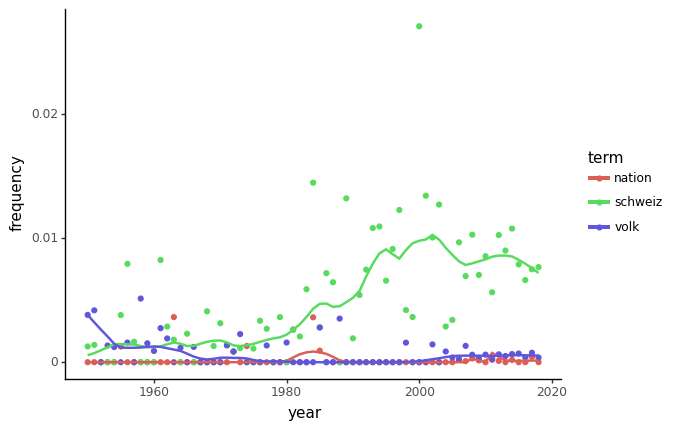

<ggplot: (8772185085283)>

In [36]:
# filter the dataset for the following terms
terms = ["volk", "schweiz", "nation"]
df_terms = df_tidy[df_tidy["term"].isin(terms)]

# plot the relative frequency for the terms above
(
    ggplot(df_terms, aes(x="year", y="frequency", color="term"))
    + geom_point()  # show individual points
    + stat_smooth(
        method="lowess", span=0.15, se=False
    )  # overlay points with a smoothed line
    + theme_classic()
)  # make the plot look nicer


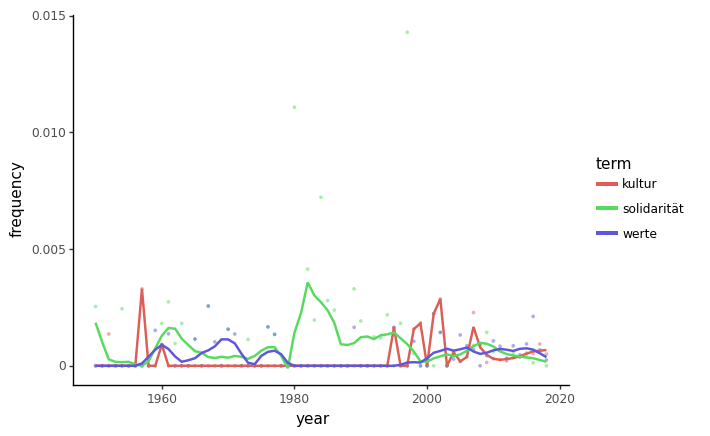

<ggplot: (8772171634241)>

In [37]:
# check some other terms
terms = ["solidarität", "kultur", "werte"]

df_terms = df_tidy[df_tidy["term"].isin(terms)]

(
    ggplot(df_terms, aes("year", "frequency", color="term"))
    + geom_point(alpha=0.5, stroke=0)
    + stat_smooth(method="lowess", span=0.10, se=False)
    + theme_classic()
)


## Save Plot

In [ ]:
# check some other terms
terms = ["schweizer", "schweizerinnen"]
df_terms = df_tidy[df_tidy["term"].isin(terms)]

p = (
    ggplot(df_terms, aes("year", "frequency", color="term"))
    + geom_point(alpha=0.5, stroke=0)  # set transparency
    + stat_smooth(method="lowess", span=0.2, se=False)
    + theme_classic()
)

# save as png
fname = "../analysis/rel_term_frq_gender.png"
p.save(filename=fname, dpi=150, verbose=False)
p


# Number of Documents per Year

In [ ]:
docs_per_year = (
    df_sub.groupby("Jahr")
    .agg({"Text": "count"})
    .reset_index()
    .rename(columns={"Text": "count"})
)

(
    ggplot(docs_per_year, aes(x="Jahr", y="count"))
    + geom_line(color="darkblue")
    + labs(title="Number of Speeches per Year", x="Year", y="absolute frequency")
    + scale_y_continuous(breaks=range(0, 18, 2), expand=(0, 1))
    + scale_x_continuous(breaks=range(1930, 2020, 10), expand=(0, 1))
    + theme_classic()
)

# Working on Mini-Project

Ask questions, <br>
I am ready to help!

![Help!](../../lectures/images/help_frog.gif)

# Resources

#### tutorials on spaCy

- [official spaCy 101](https://spacy.io/usage/spacy-101)
- [official online course spaCy](https://course.spacy.io/en/chapter1)
- [Hitchhiker's Guide to NLP in spaCy](https://www.kaggle.com/nirant/hitchhiker-s-guide-to-nlp-in-spacy)